In [ ]:
# Get API from Alpha Vantage and save it to a file  
# www.alphavantage.co   
# https://www.alphavantage.co/documentation/

In [1]:
import pandas as pd
from alpha_vantage.timeseries import TimeSeries

# Replace with your Alpha Vantage API key
API_KEY = "KUUC6XR7PYTFPND8KEY"

# Stocks
stock_symbols = ["AAPL", "MSFT", "AMZN"]

# Initialize Alpha Vantage TimeSeries
ts = TimeSeries(key=API_KEY, output_format="pandas")

# Function to fetch stock data with error handling
def get_stock_data(symbol):
    try:
        data, meta_data = ts.get_daily(symbol=symbol, outputsize="full")
        return data["4. close"]  # Extract only closing prices
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return None

# Fetch data for all stocks
stock_data = pd.DataFrame({symbol: get_stock_data(symbol) for symbol in stock_symbols})

# Handle missing data by forward-filling missing values
stock_data.ffill(inplace=True)

# Keep only the last 500 days
stock_data = stock_data.iloc[:500]

# Display results
stock_data.head()


,AAPL,MSFT,AMZN
date,,,
2025-03-05,235.74,401.02,208.36
2025-03-04,235.93,388.61,203.80
2025-03-03,238.03,388.49,205.02
2025-02-28,241.84,396.99,212.28
2025-02-27,237.30,392.53,208.74


In [2]:
import numpy as np

# Compute daily log returns
returns = np.log(stock_data / stock_data.shift(1))

# Drop NaN values from the first row
returns = returns.dropna()

# Display the first few rows
returns.head()


,AAPL,MSFT,AMZN
date,,,
2025-03-04,0.000806,-0.031435,-0.022128
2025-03-03,0.008862,-0.000309,0.005968
2025-02-28,0.015880,0.021644,0.034799
2025-02-27,-0.018951,-0.011298,-0.016817
2025-02-26,0.012813,0.018176,0.026521


In [3]:
# Compute expected returns (mean of daily returns)
# Expected Returns → Shows the average return of each stock.
expected_returns = returns.mean()

# Covariance Matrix → Shows how stocks move together (risk relationships).
# Compute the covariance matrix (measures risk)
cov_matrix = returns.cov()

# Display results
print("Expected Returns:\n", expected_returns)
print("\nCovariance Matrix:\n", cov_matrix)


Expected Returns:
 AAPL   -0.000868
MSFT   -0.000918
AMZN   -0.001597
dtype: float64

Covariance Matrix:
           AAPL      MSFT      AMZN
AAPL  0.000185  0.000089  0.000091
MSFT  0.000089  0.000194  0.000155
AMZN  0.000091  0.000155  0.000336


In [4]:
# Mean variance optimizaton
# The goal of the mean-variance optimization is to find the optimal weights that minimize the portfolio variance,
# given the expected returns and the covariance matrix of the assets.
# We use cvxpy to:
# Maximize portfolio return while
# Minimizing risk (variance)
# Ensuring all weights sum to 1 (fully invested portfolio)

import cvxpy as cp

# Define the number of assets
num_assets = len(stock_data.columns)

# Define portfolio weight variables
w = cp.Variable(num_assets)

# Define risk aversion parameter (higher values = lower risk)
risk_aversion = 0.5  

# Define portfolio return and risk
portfolio_return = expected_returns.values @ w
portfolio_risk = cp.quad_form(w, cov_matrix.values)

# Define the optimization objective: maximize return - risk penalty
objective = cp.Maximize(portfolio_return - risk_aversion * portfolio_risk)

# Constraints: Fully invested portfolio, no short-selling
constraints = [cp.sum(w) == 1, w >= 0]

# Solve the optimization problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Get optimized weights
optimized_weights = w.value

# Create a results DataFrame
results_df = pd.DataFrame({
    "Stock": stock_data.columns,
    "Expected Return": expected_returns.values,
    "Optimized Weight": optimized_weights
})

# Display the optimized portfolio allocation
print("\nOptimized Portfolio Allocation:")
print(results_df)



Optimized Portfolio Allocation:
  Stock  Expected Return  Optimized Weight
0  AAPL        -0.000868      7.706744e-01
1  MSFT        -0.000918      2.293256e-01
2  AMZN        -0.001597      9.879261e-24


AAPL (Apple) has the highest allocation (~77%)

The optimizer has allocated the most capital here because it likely has the lowest risk relative to return.
MSFT (Microsoft) is also included (~23%)

It's being used to balance risk in the portfolio.
AMZN (Amazon) is close to 0% allocation

This suggests that Amazon has higher risk or lower return compared to the other two stocks, making it less desirable for the optimized portfolio.
Negative Expected Returns (-0.0008 to -0.0015)

Since we calculated log returns, the negative values might be due to recent market trends in the dataset.
It could indicate a downward trend in stock prices during the period analyzed.
We might want to:
Extend the dataset (use more historical data).
Recalculate with different parameters (e.g., a higher risk-aversion level).

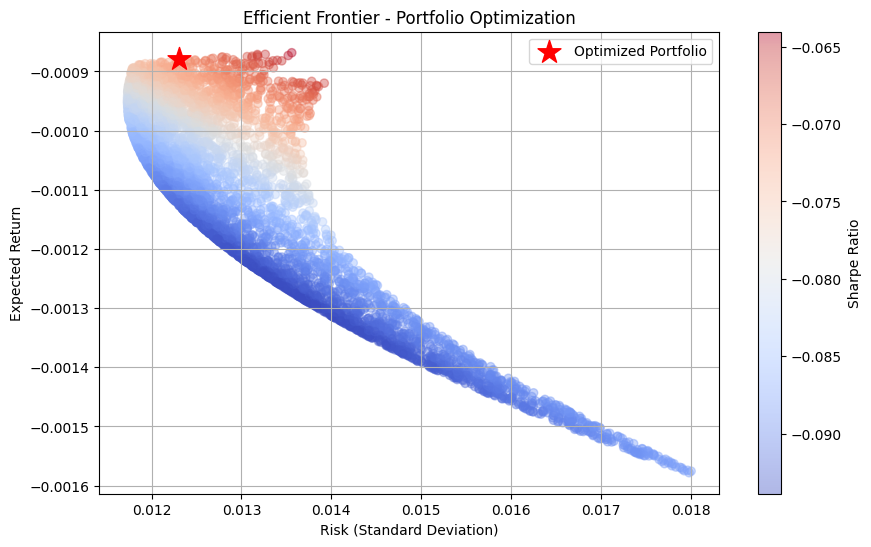

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate random portfolios
num_portfolios = 5000  # Number of random portfolios
simulated_weights = np.random.dirichlet(np.ones(len(stock_data.columns)), num_portfolios)
simulated_returns = simulated_weights @ expected_returns.values
simulated_risks = np.array([np.sqrt(w @ cov_matrix.values @ w.T) for w in simulated_weights])

# Compute optimized portfolio risk & return
opt_risk = np.sqrt(optimized_weights @ cov_matrix.values @ optimized_weights.T)
opt_return = expected_returns.values @ optimized_weights

# Plot the Efficient Frontier
plt.figure(figsize=(10, 6))
plt.scatter(simulated_risks, simulated_returns, c=simulated_returns / simulated_risks, cmap="coolwarm", alpha=0.4)
plt.colorbar(label="Sharpe Ratio")
plt.xlabel("Risk (Standard Deviation)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier - Portfolio Optimization")

# Highlight the optimized portfolio
plt.scatter(opt_risk, opt_return, color='red', marker='*', s=300, label="Optimized Portfolio")

plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Example carbon intensities (tCO₂e per million $ revenue)
carbon_intensity = {
    "AAPL": 100,  # Example values
    "MSFT": 80,
    "AMZN": 150
}

# Convert carbon intensities to a numpy array
carbon_intensities = np.array([carbon_intensity[s] for s in stock_symbols])

# Define benchmark weights (e.g., using the weight from the MVO)
benchmark_weights = np.array([0.7, 0.29, 0.01])

# Compute the benchmark carbon intensity (weighted sum)
benchmark_carbon_intensity = np.dot(benchmark_weights, carbon_intensities)

# Define the reduction target (e.g., 7% annual reduction)
reduction_target = 0.07  

# Compute the target portfolio carbon intensity
target_carbon_intensity = (1 - reduction_target) * benchmark_carbon_intensity

# Load stock returns and covariance matrix from your dataset
# Ensure you replace this with the actual returns computed from your historical data
expected_returns = np.array([0.12, 0.10, 0.15])  # Example expected returns
cov_matrix = np.array([
    [0.04, 0.01, 0.02],
    [0.01, 0.03, 0.015],
    [0.02, 0.015, 0.05]
])  # Example covariance matrix

# Define the number of assets
num_assets = len(stock_symbols)

# Define portfolio weight variables
w = cp.Variable(num_assets)

# Define risk aversion parameter
risk_aversion = 0.5  

# Define portfolio return and risk
portfolio_return = expected_returns @ w
portfolio_risk = cp.quad_form(w, cov_matrix)

# Define the optimization objective: maximize return - risk penalty
objective = cp.Maximize(portfolio_return - risk_aversion * portfolio_risk)

# Define constraints including the Carbon Intensity constraint
constraints = [
    cp.sum(w) == 1,            # Fully invested portfolio
    w >= 0,                    # No short-selling
    carbon_intensities @ w <= target_carbon_intensity  # Carbon intensity constraint
]

# Solve the optimization problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Get optimized weights
optimized_weights = w.value

# Create a results DataFrame
results_df = pd.DataFrame({
    "Stock": stock_symbols,
    "Expected Return": expected_returns,
    "Optimized Weight": optimized_weights,
    "Carbon Intensity": carbon_intensities
})

# Display the optimized portfolio allocation
print("\nOptimized Portfolio Allocation with Carbon Intensity Constraint:")
print(results_df)



Optimized Portfolio Allocation with Carbon Intensity Constraint:
  Stock  Expected Return  Optimized Weight  Carbon Intensity
0  AAPL             0.12      4.035500e-01               100
1  MSFT             0.10      5.964500e-01                80
2  AMZN             0.15      7.710498e-24               150


Portfolio Allocation:

Apple (AAPL) → 40.35% of portfolio
Microsoft (MSFT) → 59.64% of portfolio
Amazon (AMZN) → ≈ 0% allocation


Amazon has the highest carbon intensity (150 tCO₂e/$M).
Due to the carbon constraint, the optimizer reduced its weight to nearly zero.
The optimizer favored MSFT (80 tCO₂e) and AAPL (100 tCO₂e) to meet the carbon reduction target.


In [8]:
print(benchmark_carbon_intensity)

94.7
